In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
import optuna
from sklearn.datasets import make_regression
from tqdm import tqdm
import math
import shap
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

In [69]:
df = pd.read_csv('/Users/victorabsil/Desktop/EssecxCentrale/Hackathon_Eleven/final_data/merged_datasets_with_events.csv',sep =',')

# Deleting the covid period
covid_start = '2020-03-01'
covid_stop = '2022-01-01'
df = df[(df['WORK_DATE'] < covid_start) | (df['WORK_DATE'] > covid_stop)]

df.head()


,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,...,humidity,wind_speed,rain_1h,rain_3h,snow_1h,weather_description,REF_CLOSING_DESCRIPTION,ATTENDANCE,NIGHT_SHOW_FLAG,PARADE_FLAG
0,2018-06-01,2018-06-01 19:00:00,19,2018-06-01 19:15:00.000,Roller Coaster,15,2.0,50.0,75.00,75.00,...,89,1.59,0.22,0.0,0.0,light rain,Open,46804.0,0,0
1,2018-06-01,2018-06-01 20:30:00,20,2018-06-01 20:45:00.000,Zipline,40,12.0,69.0,101.25,101.25,...,93,1.67,0.20,0.0,0.0,light rain,Open,46804.0,0,0
2,2018-06-01,2018-06-01 16:30:00,16,2018-06-01 16:45:00.000,Spinning Coaster,15,5.0,283.0,526.25,438.50,...,87,2.94,0.23,0.0,0.0,light rain,Open,46804.0,0,0
3,2018-06-01,2018-06-01 20:30:00,20,2018-06-01 20:45:00.000,Giant Wheel,30,4.0,0.0,503.75,0.00,...,93,1.67,0.20,0.0,0.0,light rain,Open,46804.0,0,0
4,2018-06-01,2018-06-01 13:45:00,13,2018-06-01 14:00:00.000,Oz Theatre,0,0.0,0.0,0.00,0.00,...,77,1.92,0.31,0.0,0.0,light rain,Fermeture Opérationnelle,46804.0,0,0


In [70]:
# Encoding

#Time management 
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])

df['month'] = df['WORK_DATE'].dt.month
df['day'] = df['WORK_DATE'].dt.day
df['weekday'] = df['WORK_DATE'].dt.dayofweek
df.drop(columns=['WORK_DATE'])

df['hour'] = df['DEB_TIME'].dt.hour
df['minute'] = df['DEB_TIME'].dt.minute
df.drop(columns=['DEB_TIME'])
df.drop(columns=['FIN_TIME'])

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,...,weather_description,REF_CLOSING_DESCRIPTION,ATTENDANCE,NIGHT_SHOW_FLAG,PARADE_FLAG,month,day,weekday,hour,minute
0,2018-06-01,2018-06-01 19:00:00,19,Roller Coaster,15,2.0,50.0,75.00,75.00,15,...,light rain,Open,46804.0,0,0,6,1,4,19,0
1,2018-06-01,2018-06-01 20:30:00,20,Zipline,40,12.0,69.0,101.25,101.25,15,...,light rain,Open,46804.0,0,0,6,1,4,20,30
2,2018-06-01,2018-06-01 16:30:00,16,Spinning Coaster,15,5.0,283.0,526.25,438.50,15,...,light rain,Open,46804.0,0,0,6,1,4,16,30
3,2018-06-01,2018-06-01 20:30:00,20,Giant Wheel,30,4.0,0.0,503.75,0.00,15,...,light rain,Open,46804.0,0,0,6,1,4,20,30
4,2018-06-01,2018-06-01 13:45:00,13,Oz Theatre,0,0.0,0.0,0.00,0.00,0,...,light rain,Fermeture Opérationnelle,46804.0,0,0,6,1,4,13,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604473,2022-07-26,2022-07-26 20:00:00,20,Roller Coaster,0,1.0,0.0,0.00,0.00,0,...,overcast clouds,Open,26391.0,0,0,7,26,1,20,0
1604474,2022-07-26,2022-07-26 20:45:00,20,Spiral Slide,0,1.0,0.0,0.00,0.00,0,...,overcast clouds,Open,26391.0,0,0,7,26,1,20,45
1604475,2022-07-26,2022-07-26 20:30:00,20,Free Fall,0,1.0,0.0,0.00,0.00,0,...,overcast clouds,Open,26391.0,0,0,7,26,1,20,30
1604476,2022-07-26,2022-07-26 22:15:00,22,Free Fall,0,1.0,0.0,0.00,0.00,0,...,broken clouds,Open,26391.0,0,0,7,26,1,22,15


In [71]:
# ------------------------------------------------------------------------------
# 1. Extraction des horaires d'ouverture depuis le DataFrame d'origine
# ------------------------------------------------------------------------------

opening_hours = {}
for day, group in df.groupby('WORK_DATE'):
    # Récupérer l'heure minimale et maximale du jour
    open_hour = group['DEB_TIME_HOUR'].min()
    close_hour = group['DEB_TIME_HOUR'].max()
    opening_hours[day] = (open_hour, close_hour)

print("Horaires d'ouverture extraits :", opening_hours)

Horaires d'ouverture extraits : {Timestamp('2018-06-01 00:00:00'): (9, 22), Timestamp('2018-06-02 00:00:00'): (9, 22), Timestamp('2018-06-03 00:00:00'): (9, 22), Timestamp('2018-06-04 00:00:00'): (9, 22), Timestamp('2018-06-05 00:00:00'): (9, 22), Timestamp('2018-06-06 00:00:00'): (9, 22), Timestamp('2018-06-07 00:00:00'): (9, 22), Timestamp('2018-06-08 00:00:00'): (9, 22), Timestamp('2018-06-09 00:00:00'): (9, 22), Timestamp('2018-06-10 00:00:00'): (9, 22), Timestamp('2018-06-11 00:00:00'): (9, 22), Timestamp('2018-06-12 00:00:00'): (9, 22), Timestamp('2018-06-13 00:00:00'): (9, 22), Timestamp('2018-06-14 00:00:00'): (9, 22), Timestamp('2018-06-15 00:00:00'): (9, 22), Timestamp('2018-06-16 00:00:00'): (9, 22), Timestamp('2018-06-17 00:00:00'): (9, 22), Timestamp('2018-06-18 00:00:00'): (9, 22), Timestamp('2018-06-19 00:00:00'): (9, 22), Timestamp('2018-06-20 00:00:00'): (9, 22), Timestamp('2018-06-21 00:00:00'): (9, 22), Timestamp('2018-06-22 00:00:00'): (9, 22), Timestamp('2018-06-23

In [72]:
#Cyclic function to capture the cyclique evolution of the day 

def encode_cyclic_feature(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    df = df.drop(columns=[col])  # Delete the original column 
    return df


df = encode_cyclic_feature(df, 'month', 12) 
df = encode_cyclic_feature(df, 'day', 31)  
df = encode_cyclic_feature(df, 'weekday', 7)  
df = encode_cyclic_feature(df, 'hour', 24)  
df = encode_cyclic_feature(df, 'minute', 60) 

In [73]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
print("Variables numériques :", numerical_features)

Variables numériques : ['NB_UNITS', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY', 'NB_MAX_UNIT', 'temp', 'feels_like', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h', 'ATTENDANCE', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']


In [74]:
df = df.drop(columns=['DEB_TIME_HOUR', 'NB_UNITS', 'GUEST_CARRIED', 'NB_MAX_UNIT', 'temp', 'humidity', 'DEB_TIME', 'WORK_DATE', 
                      'FIN_TIME', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h','DOWNTIME'])

df.columns

Index(['ENTITY_DESCRIPTION_SHORT', 'WAIT_TIME_MAX', 'CAPACITY',
       'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME', 'feels_like',
       'weather_description', 'REF_CLOSING_DESCRIPTION', 'ATTENDANCE',
       'NIGHT_SHOW_FLAG', 'PARADE_FLAG', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos',
       'minute_sin', 'minute_cos'],
      dtype='object')

In [75]:
weather_mapping = {'sky is clear' : 10 ,'few clouds' : 9 , 'scattered clouds' : 8 , 'broken clouds' : 7, 'overcast clouds' : 6, 'light snow' : 5, 'light rain' : 4, 'snow' : 3, 'moderate rain' : 2, 'heavy intensity rain' : 1}

df['weather_description'] = df['weather_description'].map(weather_mapping)

In [76]:
df['REF_CLOSING_DESCRIPTION'] = df['REF_CLOSING_DESCRIPTION'].isin(['Open', 'Fermeture Opérationnelle'])
closing_mapping = {'Open' : 1, 'Fermeture Opérationnelle' : 0}

df['REF_CLOSING_DESCRIPTION'] = df['REF_CLOSING_DESCRIPTION'].map(closing_mapping)

In [77]:
categorical_cols = ['ENTITY_DESCRIPTION_SHORT']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

In [78]:
columnslist = []
for columns in df:
    print(f'Columns name :', columns, " & type :", df[columns].dtypes)
    if columns != 'WAIT_TIME_MAX':
        columnslist.append(columns)

print(columnslist)


Columns name : WAIT_TIME_MAX  & type : int64
Columns name : CAPACITY  & type : float64
Columns name : ADJUST_CAPACITY  & type : float64
Columns name : OPEN_TIME  & type : int64
Columns name : UP_TIME  & type : int64
Columns name : feels_like  & type : float64
Columns name : weather_description  & type : int64
Columns name : REF_CLOSING_DESCRIPTION  & type : float64
Columns name : ATTENDANCE  & type : float64
Columns name : NIGHT_SHOW_FLAG  & type : int64
Columns name : PARADE_FLAG  & type : int64
Columns name : month_sin  & type : float64
Columns name : month_cos  & type : float64
Columns name : day_sin  & type : float64
Columns name : day_cos  & type : float64
Columns name : weekday_sin  & type : float64
Columns name : weekday_cos  & type : float64
Columns name : hour_sin  & type : float64
Columns name : hour_cos  & type : float64
Columns name : minute_sin  & type : float64
Columns name : minute_cos  & type : float64
Columns name : ENTITY_DESCRIPTION_SHORT_Bungee Jump  & type : int64


In [79]:
df.columns

Index(['WAIT_TIME_MAX', 'CAPACITY', 'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME',
       'feels_like', 'weather_description', 'REF_CLOSING_DESCRIPTION',
       'ATTENDANCE', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'ENTITY_DESCRIPTION_SHORT_Bungee Jump',
       'ENTITY_DESCRIPTION_SHORT_Circus Train',
       'ENTITY_DESCRIPTION_SHORT_Crazy Dance',
       'ENTITY_DESCRIPTION_SHORT_Dizzy Dropper',
       'ENTITY_DESCRIPTION_SHORT_Drop Tower',
       'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
       'ENTITY_DESCRIPTION_SHORT_Free Fall',
       'ENTITY_DESCRIPTION_SHORT_Giant Wheel',
       'ENTITY_DESCRIPTION_SHORT_Giga Coaster',
       'ENTITY_DESCRIPTION_SHORT_Go-Karts',
       'ENTITY_DESCRIPTION_SHORT_Haunted House',
       'ENTITY_DESCRIPTION_SHORT_Himalaya Ride',
       'ENTITY_DESCRIPTION_SHORT_Inverted Coaster',
       'ENTITY_DESCRIPTION_SHO

In [80]:
#Train test split 
np.random.seed(42)
df_fin = df[['ATTENDANCE', 'ADJUST_CAPACITY', 'feels_like', 'weather_description',
        'REF_CLOSING_DESCRIPTION', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG',
        'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 
        'weekday_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'ENTITY_DESCRIPTION_SHORT_Bungee Jump',
       'ENTITY_DESCRIPTION_SHORT_Circus Train',
       'ENTITY_DESCRIPTION_SHORT_Crazy Dance',
       'ENTITY_DESCRIPTION_SHORT_Dizzy Dropper',
       'ENTITY_DESCRIPTION_SHORT_Drop Tower',
       'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
       'ENTITY_DESCRIPTION_SHORT_Free Fall',
       'ENTITY_DESCRIPTION_SHORT_Giant Wheel',
       'ENTITY_DESCRIPTION_SHORT_Giga Coaster',
       'ENTITY_DESCRIPTION_SHORT_Go-Karts',
       'ENTITY_DESCRIPTION_SHORT_Haunted House',
       'ENTITY_DESCRIPTION_SHORT_Himalaya Ride',
       'ENTITY_DESCRIPTION_SHORT_Inverted Coaster',
       'ENTITY_DESCRIPTION_SHORT_Kiddie Coaster',
       'ENTITY_DESCRIPTION_SHORT_Merry Go Round',
       'ENTITY_DESCRIPTION_SHORT_Oz Theatre',
       'ENTITY_DESCRIPTION_SHORT_Rapids Ride',
       'ENTITY_DESCRIPTION_SHORT_Roller Coaster',
       'ENTITY_DESCRIPTION_SHORT_Spinning Coaster',
       'ENTITY_DESCRIPTION_SHORT_Spiral Slide',
       'ENTITY_DESCRIPTION_SHORT_Superman Ride',
       'ENTITY_DESCRIPTION_SHORT_Swing Ride',
       'ENTITY_DESCRIPTION_SHORT_Vertical Drop',
       'ENTITY_DESCRIPTION_SHORT_Water Ride',
       'ENTITY_DESCRIPTION_SHORT_Zipline']]

y = df['WAIT_TIME_MAX']
X_train, X_test, y_train, y_test = train_test_split(df_fin, y,test_size=0.2, random_state=42)

In [81]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 7, 12],
    'subsample': [0.4, 0.8],
    'gamma': [0,2, 3],
    'random_state': [42]
}


In [82]:
def objective(trial):
    # Création des paramètres à partir de la grille
    params = {key: trial.suggest_categorical(key, values) for key, values in param_grid.items()}
    
    # Entraînement du modèle XGBoost avec MAE comme métrique
    model = xgb.XGBRegressor(**params, objective='reg:squarederror', eval_metric="mae")
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Forcer toutes les prédictions à être >= 0
    y_pred = np.maximum(0, y_pred)

    # Calcul du MAE sur les valeurs corrigées
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Calcul du nombre total d'essais (produit des tailles des listes de la grille)
total_trials = math.prod([len(values) for values in param_grid.values()])

# Création de la barre de progression tqdm
pbar = tqdm(total=total_trials, desc="Grid Search Trials", unit="trial")

# Callback simple : incrémente la barre de 1 à chaque essai terminé
def progress_callback(study, trial):
    pbar.update(1)

# Initialisation du GridSampler avec la grille définie
sampler = optuna.samplers.GridSampler(param_grid)

# Création de l'étude (on minimise le MAE)
study = optuna.create_study(sampler=sampler, direction="minimize")

# Lancement de l'optimisation en passant le callback pour mettre à jour tqdm
study.optimize(objective, callbacks=[progress_callback])
pbar.close()

# Affichage final (résumé)
print("Meilleurs paramètres :", study.best_params)
print("Meilleur MAE :", study.best_value)

Grid Search Trials:   0%|          | 0/162 [00:00<?, ?trial/s][I 2025-02-13 16:35:30,884] A new study created in memory with name: no-name-d202309e-598c-4471-8664-0f70437a081a
[I 2025-02-13 16:35:36,448] Trial 0 finished with value: 9.425077970810243 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 12, 'subsample': 0.4, 'gamma': 2, 'random_state': 42}. Best is trial 0 with value: 9.425077970810243.
Grid Search Trials: 100%|██████████| 162/162 [18:01<00:00,  6.68s/trial]

Meilleurs paramètres : {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 0.8, 'gamma': 2, 'random_state': 42}
Meilleur MAE : 3.297622748737799


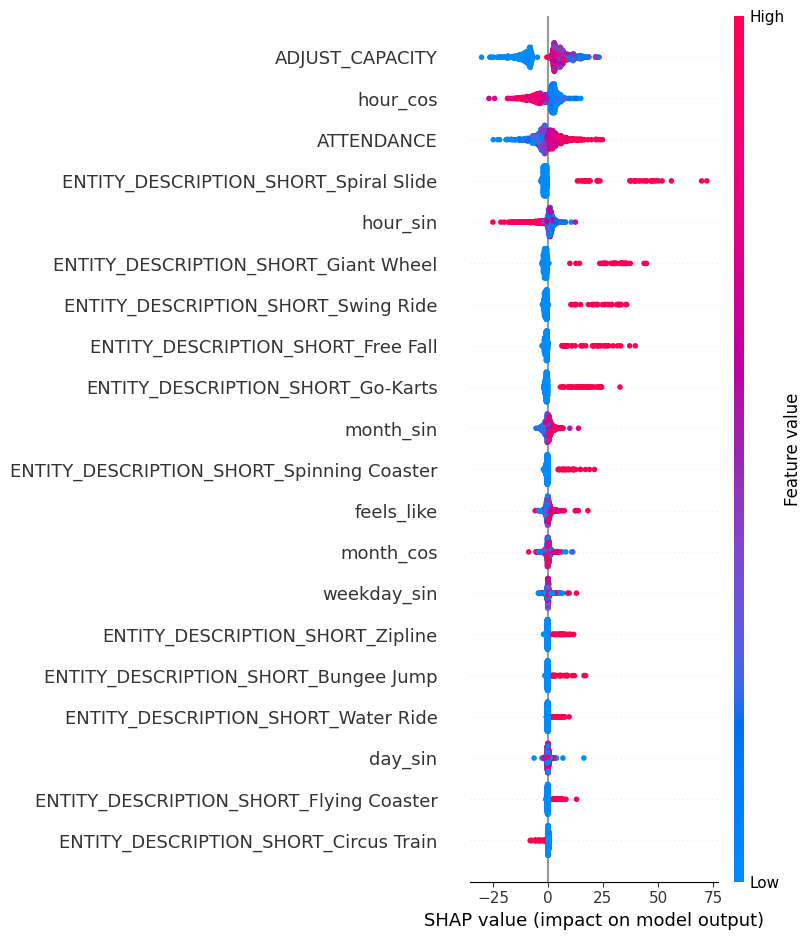

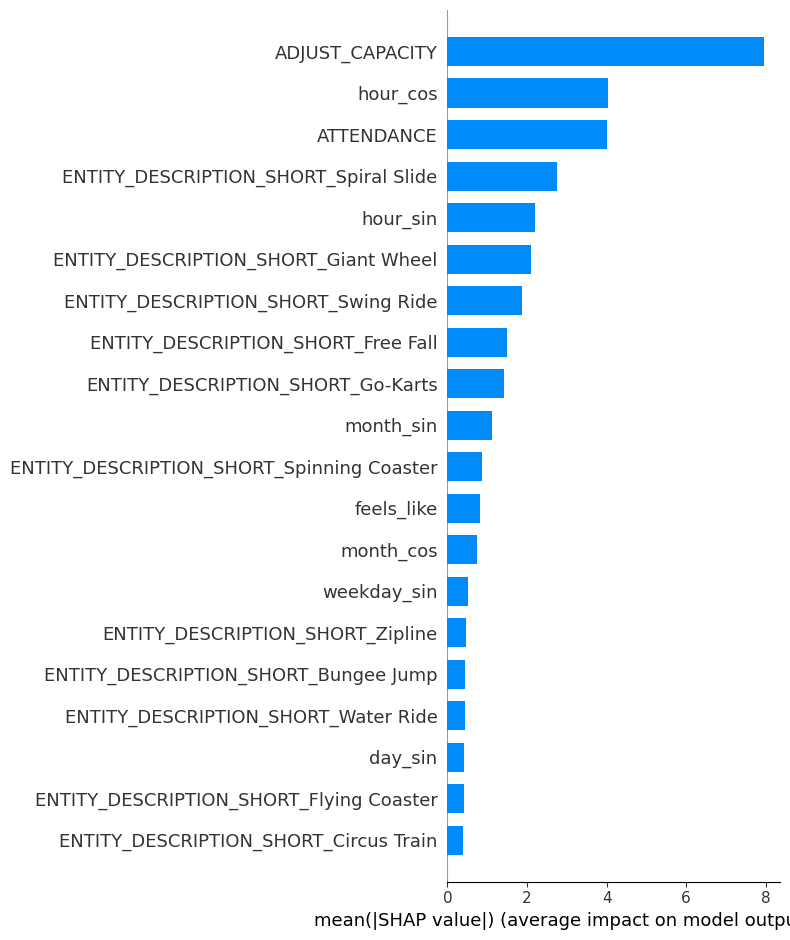

In [83]:
# -------------------------------
# Analyse SHAP sur le meilleur modèle
# -------------------------------

# 1. Entraînement du meilleur modèle sur l'ensemble d'entraînement
best_model = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# 2. Création d'un explainer SHAP pour les modèles basés sur des arbres
explainer = shap.TreeExplainer(best_model)

X_sample = X_train.sample(n=1000, random_state=42)

# 3. Calcul des valeurs SHAP sur l'ensemble d'entraînement
shap_values = explainer.shap_values(X_sample)

# 4. Visualisation de l'importance des features via un summary plot
shap.summary_plot(shap_values, X_sample)

# Vous pouvez également afficher un summary plot de type "bar" pour une vue plus synthétique
shap.summary_plot(shap_values, X_sample, plot_type="bar")

Features dont l'impact est quasiment nul (mean abs SHAP < 0.01):
                                   feature  mean_abs_shap
4                  REF_CLOSING_DESCRIPTION       0.000000
39  ENTITY_DESCRIPTION_SHORT_Vertical Drop       0.006586


<Figure size 1000x600 with 0 Axes>

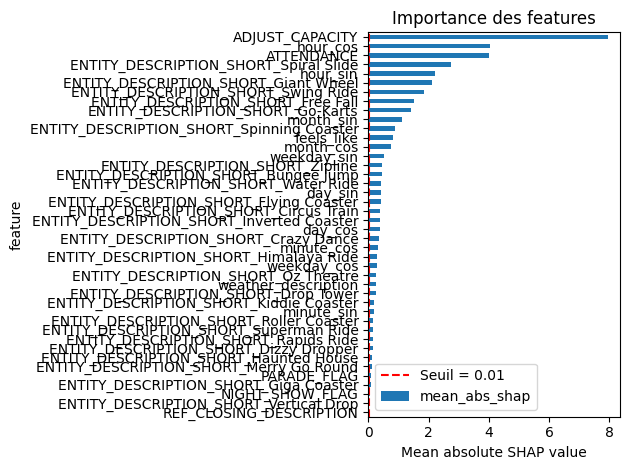

In [84]:
# Calcul de la moyenne des valeurs absolues SHAP pour chaque feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Création d'un DataFrame récapitulatif avec le nom de chaque feature et sa moyenne des valeurs absolues SHAP
df_feature_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
})

# Définition d'un seuil : ici, on considère qu'une feature a un impact quasi nul si sa valeur moyenne absolue est inférieure à 0.01
threshold = 0.01

# Filtrer les features dont l'impact est inférieur au seuil
low_impact_features = df_feature_shap[df_feature_shap['mean_abs_shap'] < threshold]

print("Features dont l'impact est quasiment nul (mean abs SHAP < {}):".format(threshold))
print(low_impact_features)

# Optionnel : affichage d'un plot bar pour visualiser toutes les features avec leur impact
plt.figure(figsize=(10,6))
df_feature_shap.sort_values(by='mean_abs_shap', ascending=True).plot.barh(x='feature', y='mean_abs_shap', legend=False)
plt.axvline(threshold, color='red', linestyle='--', label=f'Seuil = {threshold}')
plt.xlabel("Mean absolute SHAP value")
plt.title("Importance des features")
plt.legend()
plt.tight_layout()
plt.show()

Performance du best_model sur le jeu de test :
MAE   : 3.297622748737799
MSE   : 42.81206780148286
RMSE  : 6.543093137154847
R²    : 0.9187807440757751


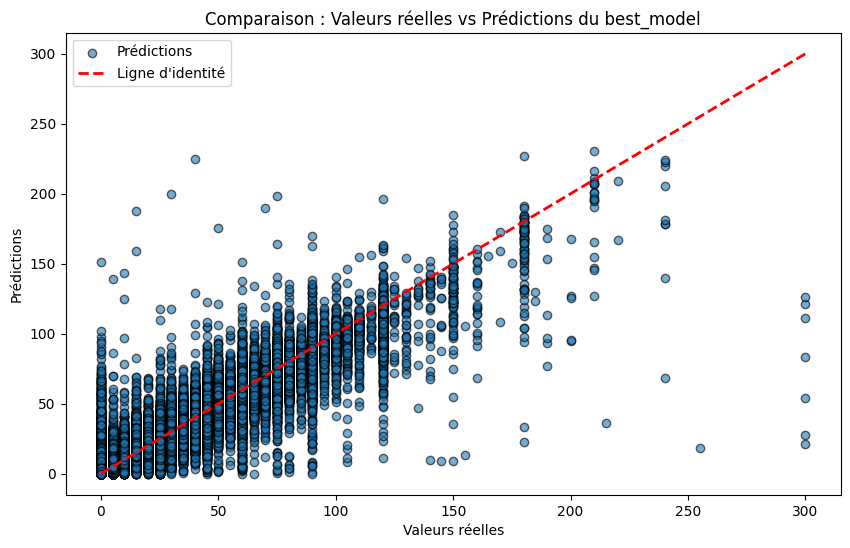

In [85]:
# 1. Appliquer le best_model sur le jeu de test
y_pred = best_model.predict(X_test)
y_pred = np.maximum(0, y_pred)  # Remplace toutes les valeurs négatives par 0

# 2. Calculer les métriques d'évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Performance du best_model sur le jeu de test :")
print("MAE   :", mae)
print("MSE   :", mse)
print("RMSE  :", rmse)
print("R²    :", r2)

# 3. Comparer graphiquement les valeurs réelles et les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label="Prédictions")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison : Valeurs réelles vs Prédictions du best_model")

# Tracer la ligne d'identité (où y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ligne d'identité")

plt.legend()
plt.show()

/var/folders/fq/m6rlxfs17vl39gr2jlybg8440000gn/T/ipykernel_28213/2450003308.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2020-01-01", periods=n_obs_day, freq="H")


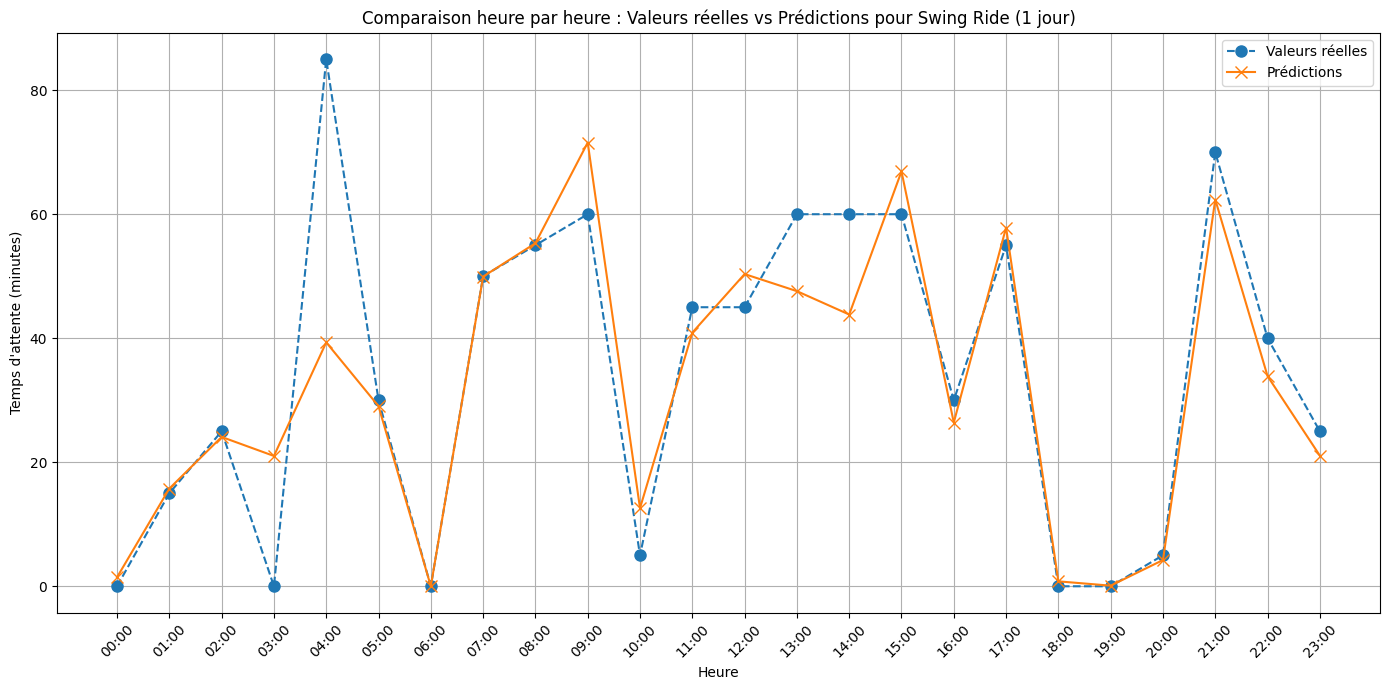

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Filtrage sur l'attraction "Swing Ride" ---
mask_entity = X_test["ENTITY_DESCRIPTION_SHORT_Swing Ride"] == 1
X_test_entity = X_test[mask_entity].copy()   # Copie pour éviter des problèmes de modification
y_test_entity = y_test[mask_entity]

# --- Sélection pour une journée spécifique ---
# On suppose que les 24 premières observations représentent 1 jour.
n_obs_day = 24
if len(X_test_entity) < n_obs_day:
    n_obs_day = len(X_test_entity)
    
X_test_day = X_test_entity.iloc[:n_obs_day]
y_test_day = y_test_entity.iloc[:n_obs_day]

# --- Ensure that negative actual values are set to 0 ---
y_test_day = np.maximum(0, y_test_day)

# --- Création d'un index temporel synthétique pour 1 jour ---
time_index = pd.date_range(start="2020-01-01", periods=n_obs_day, freq="H")

# --- Préparation des données pour la prédiction ---
X_test_day_model = X_test_day.copy()

# --- Prédictions avec le best_model ---
y_pred_day = best_model.predict(X_test_day_model)
y_pred_day = np.maximum(0, y_pred_day)  # Forcer les valeurs négatives à être >= 0

# --- Création d'un DataFrame pour le tracé ---
df_results = pd.DataFrame({
    "Réel": y_test_day.values,
    "Prédiction": y_pred_day
}, index=time_index)

# --- Tracé de la série temporelle pour la journée ---
plt.figure(figsize=(14, 7))
plt.plot(df_results.index, df_results["Réel"], label="Valeurs réelles", marker="o", markersize=8, linestyle="--")
plt.plot(df_results.index, df_results["Prédiction"], label="Prédictions", marker="x", markersize=8, linestyle="-")
plt.xlabel("Heure")
plt.ylabel("Temps d'attente (minutes)")
plt.title("Comparaison heure par heure : Valeurs réelles vs Prédictions pour Swing Ride (1 jour)")
plt.legend()
plt.grid(True)

# Formatter l'axe x pour afficher l'heure au format HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(time_index, [t.strftime("%H:%M") for t in time_index], rotation=45)
plt.tight_layout()
plt.show()

/var/folders/fq/m6rlxfs17vl39gr2jlybg8440000gn/T/ipykernel_28213/2847208208.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2025-01-01", periods=n_hours_month, freq="H")


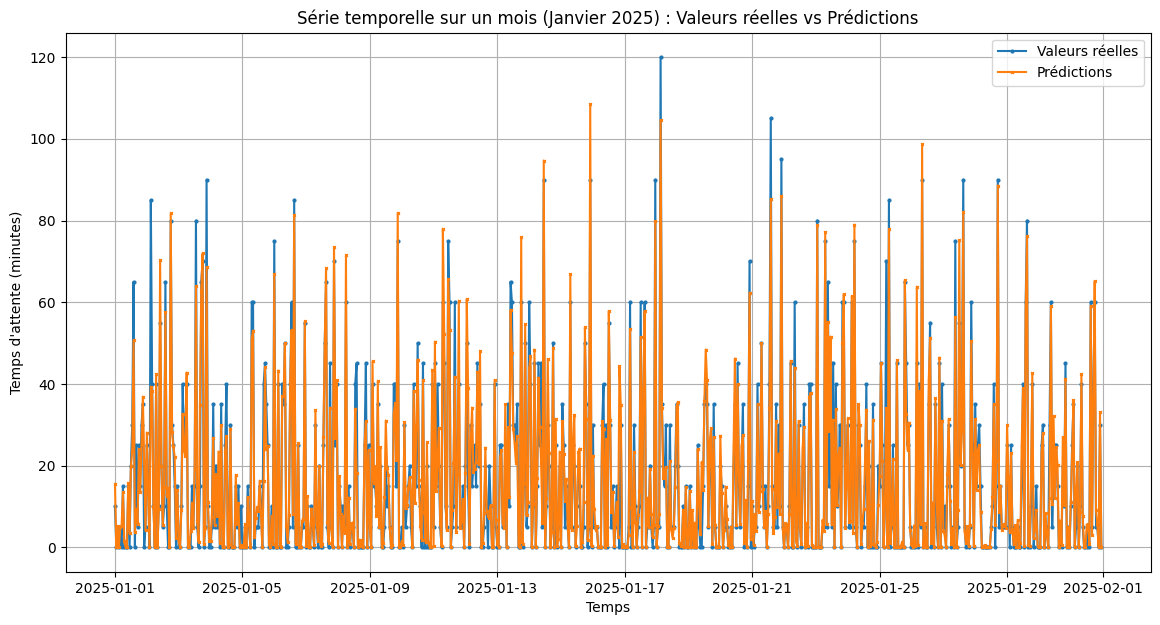

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Appliquer le best_model sur le jeu de test
y_pred = best_model.predict(X_test)

# Forcer les valeurs négatives à 0
y_pred = np.maximum(0, y_pred)

# 2. Création d'un index temporel pour un mois (ici janvier 2025)
n_hours_month = 31 * 24  # 744 heures pour un mois de 31 jours

if len(y_test) >= n_hours_month:
    # Si le jeu de test contient au moins un mois de données, on prend les 744 premières observations
    time_index = pd.date_range(start="2025-01-01", periods=n_hours_month, freq="H")
    df_results = pd.DataFrame({
        "Réel": y_test.values[:n_hours_month],
        "Prédiction": y_pred[:n_hours_month]
    }, index=time_index)
else:
    # Sinon, on crée un index de la longueur disponible
    time_index = pd.date_range(start="2025-01-01", periods=len(y_test), freq="H")
    df_results = pd.DataFrame({
        "Réel": y_test.values,
        "Prédiction": y_pred
    }, index=time_index)

# 3. Tracé de la série temporelle sur un mois
plt.figure(figsize=(14, 7))
plt.plot(df_results.index, df_results["Réel"], label="Valeurs réelles", marker='o', markersize=2)
plt.plot(df_results.index, df_results["Prédiction"], label="Prédictions", marker='x', markersize=2)
plt.xlabel("Temps")
plt.ylabel("Temps d'attente (minutes)")
plt.title("Série temporelle sur un mois (Janvier 2025) : Valeurs réelles vs Prédictions")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/fq/m6rlxfs17vl39gr2jlybg8440000gn/T/ipykernel_28213/2130815407.py:137: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=user_date, periods=24, freq="H")


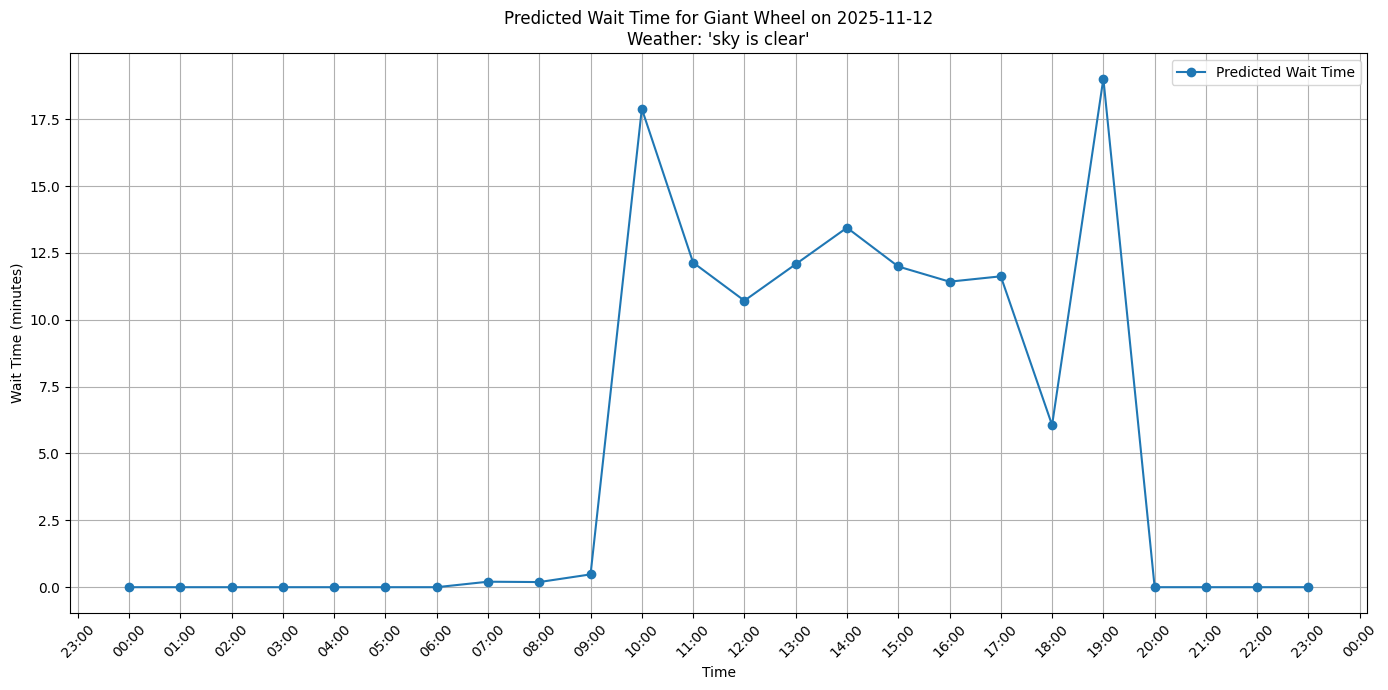

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import sin, cos, pi

def create_input_features(attraction, date_str, hour, weather_desc_str):
    """
    Creates a single-row DataFrame with the features expected by the model,
    based on:
      - attraction: e.g., "Giant Wheel"
      - date_str: a date string in the format "YYYY-MM-DD"
      - hour: an integer from 0 to 23
      - weather_desc_str: a weather description string, e.g., "sky is clear"
    
    The function computes cyclic features for month, day, weekday, hour and minute (fixed to 0).
    """
    # Create a datetime with minutes fixed to 0
    dt = pd.to_datetime(f"{date_str} {hour:02d}:00")
    
    # Extract date components
    month = dt.month
    day = dt.day
    weekday = dt.weekday()  # Monday = 0, Sunday = 6
    minute = 0
    
    # Cyclic features for date and time
    month_sin = sin(2 * pi * month / 12)
    month_cos = cos(2 * pi * month / 12)
    day_sin   = sin(2 * pi * day / 31)
    day_cos   = cos(2 * pi * day / 31)
    weekday_sin = sin(2 * pi * weekday / 7)
    weekday_cos = cos(2 * pi * weekday / 7)
    hour_sin  = sin(2 * pi * hour / 24)
    hour_cos  = cos(2 * pi * hour / 24)
    minute_sin = sin(2 * pi * minute / 60)
    minute_cos = cos(2 * pi * minute / 60)
    
    # Other features (set to default values – adjust as needed)
    attendance = 100
    adjust_capacity = 0
    feels_like = 20.0
    # Weather mapping as provided:
    weather_mapping = {
        'sky is clear': 10,
        'few clouds': 9,
        'scattered clouds': 8,
        'broken clouds': 7,
        'overcast clouds': 6,
        'light snow': 5,
        'light rain': 4,
        'snow': 3,
        'moderate rain': 2,
        'heavy intensity rain': 1
    }
    weather_description = weather_mapping.get(weather_desc_str.lower(), 10)
    ref_closing_description = 0
    night_show_flag = 0
    parade_flag = 0
    
    # List of attraction columns used during training
    attraction_cols = [
        'ENTITY_DESCRIPTION_SHORT_Bungee Jump',
        'ENTITY_DESCRIPTION_SHORT_Circus Train',
        'ENTITY_DESCRIPTION_SHORT_Crazy Dance',
        'ENTITY_DESCRIPTION_SHORT_Dizzy Dropper',
        'ENTITY_DESCRIPTION_SHORT_Drop Tower',
        'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
        'ENTITY_DESCRIPTION_SHORT_Free Fall',
        'ENTITY_DESCRIPTION_SHORT_Giant Wheel',
        'ENTITY_DESCRIPTION_SHORT_Giga Coaster',
        'ENTITY_DESCRIPTION_SHORT_Go-Karts',
        'ENTITY_DESCRIPTION_SHORT_Haunted House',
        'ENTITY_DESCRIPTION_SHORT_Himalaya Ride',
        'ENTITY_DESCRIPTION_SHORT_Inverted Coaster',
        'ENTITY_DESCRIPTION_SHORT_Kiddie Coaster',
        'ENTITY_DESCRIPTION_SHORT_Merry Go Round',
        'ENTITY_DESCRIPTION_SHORT_Oz Theatre',
        'ENTITY_DESCRIPTION_SHORT_Rapids Ride',
        'ENTITY_DESCRIPTION_SHORT_Roller Coaster',
        'ENTITY_DESCRIPTION_SHORT_Spinning Coaster',
        'ENTITY_DESCRIPTION_SHORT_Spiral Slide',
        'ENTITY_DESCRIPTION_SHORT_Superman Ride',
        'ENTITY_DESCRIPTION_SHORT_Swing Ride',
        'ENTITY_DESCRIPTION_SHORT_Vertical Drop',
        'ENTITY_DESCRIPTION_SHORT_Water Ride',
        'ENTITY_DESCRIPTION_SHORT_Zipline'
    ]
    # One-hot encoding for the attraction
    attraction_features = {col: 0 for col in attraction_cols}
    col_name = f"ENTITY_DESCRIPTION_SHORT_{attraction}"
    if col_name in attraction_features:
        attraction_features[col_name] = 1
    else:
        print(f"Warning: Attraction '{attraction}' not recognized. No one-hot will be activated.")
    
    # Assemble all features into a dictionary
    features = {
        "ATTENDANCE": attendance,
        "ADJUST_CAPACITY": adjust_capacity,
        "feels_like": feels_like,
        "weather_description": weather_description,
        "REF_CLOSING_DESCRIPTION": ref_closing_description,
        "NIGHT_SHOW_FLAG": night_show_flag,
        "PARADE_FLAG": parade_flag,
        "month_sin": month_sin,
        "month_cos": month_cos,
        "day_sin": day_sin,
        "day_cos": day_cos,
        "weekday_sin": weekday_sin,
        "weekday_cos": weekday_cos,
        "hour_sin": hour_sin,
        "hour_cos": hour_cos,
        "minute_sin": minute_sin,
        "minute_cos": minute_cos
    }
    features.update(attraction_features)
    
    return pd.DataFrame([features])

# ----- User Inputs -----
user_attraction = "Giant Wheel"       # Must match one of the attraction columns (e.g., "Giant Wheel")
user_date = "2025-11-12"              # The day for which predictions are desired (YYYY-MM-DD)
user_weather_desc = "sky is clear"    # Weather description (as per the mapping keys)

# ----- Generate predictions for each hour of the day -----
hours = range(24)
predictions = []
for h in hours:
    # Build a datetime string for each hour (minutes fixed to 00)
    input_df = create_input_features(user_attraction, user_date, h, user_weather_desc)
    pred = best_model.predict(input_df)
    pred = np.maximum(0, pred)  # Ensure non-negative predictions
    predictions.append(pred[0])

# Create a time index for the day
time_index = pd.date_range(start=user_date, periods=24, freq="H")
df_plot = pd.DataFrame({"Predicted Wait Time (minutes)": predictions}, index=time_index)

# ----- Plot the results with detailed hour-by-hour ticks -----
plt.figure(figsize=(14, 7))
plt.plot(df_plot.index, df_plot["Predicted Wait Time (minutes)"], marker="o", linestyle="-", label="Predicted Wait Time")
plt.xlabel("Time")
plt.ylabel("Wait Time (minutes)")
plt.title(f"Predicted Wait Time for {user_attraction} on {user_date}\nWeather: '{user_weather_desc}'")
plt.legend()
plt.grid(True)

# Format x-axis to show each hour
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # tick every hour
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()